# Differentiating with the LEAN algorithm
This example shows how to differentiate cycler data using the LEAN algorithm developed in: Feng X, Merla Y, Weng C, Ouyang M, He X, Liaw BY, et al. A reliable approach of differentiating discrete sampled-data for battery diagnosis. eTransportation. 2020;3: 100051. https://doi.org/10.1016/j.etran.2020.100051.
 

First import the package and dataset:

In [1]:
import pyprobe
import numpy as np
info_dictionary = {'Name': 'Sample cell',
                   'Chemistry': 'NMC622',
                   'Nominal Capacity [Ah]': 0.04,
                   'Cycler number': 1,
                   'Channel number': 1,}
data_directory = '../../../tests/sample_data/neware'

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(procedure_name='Sample',
                   folder_path = data_directory,
                   filename = 'sample_data_neware.parquet')

The break-in cycles of this dataset are at C/10, so can be analysed as pseudo-OCV curves. We're going to look at the last cycle:

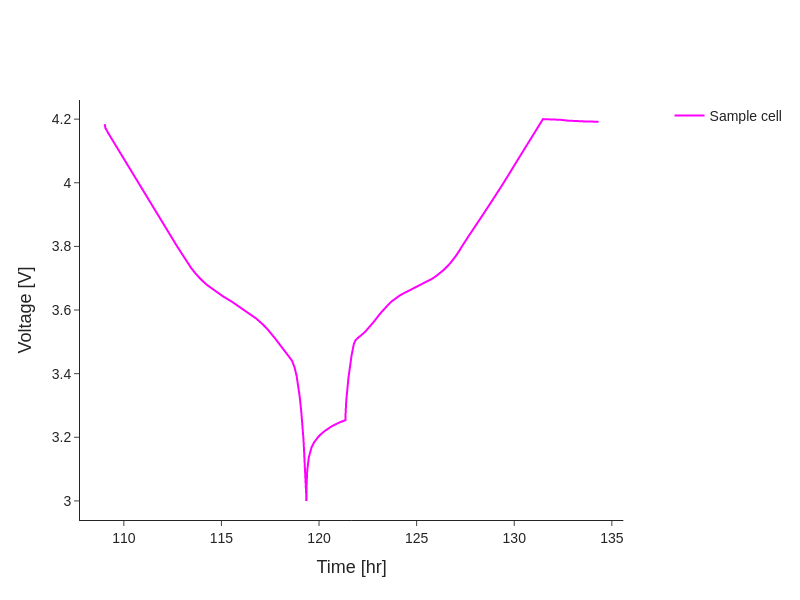

In [2]:
final_cycle= cell.procedure['Sample'].experiment('Break-in Cycles').cycle(-1)
fig = pyprobe.Plot()
fig.add_line(final_cycle, 'Time [hr]', 'Voltage [V]')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation

We start the analysis by first creating the analysis objects:

In [3]:
from pyprobe.analysis.differentiation import Differentiation

discharge_differentiation = Differentiation(input_data = final_cycle.discharge(0))
charge_differentiation = Differentiation(input_data = final_cycle.charge(0).constant_current())

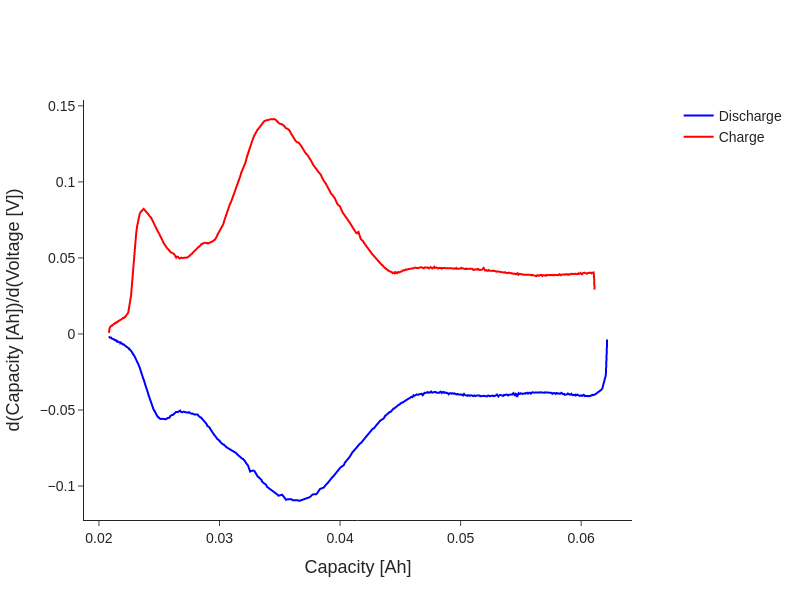

In [4]:
discharge_dQdV = discharge_differentiation.differentiate_LEAN(x = 'Capacity [Ah]', y='Voltage [V]', k = 10, gradient = 'dxdy')
charge_dQdV = charge_differentiation.differentiate_LEAN(x = 'Capacity [Ah]', y='Voltage [V]', k = 10, gradient = 'dxdy')
fig = pyprobe.Plot()
fig.add_line(discharge_dQdV, 'Capacity [Ah]', 'd(Capacity [Ah])/d(Voltage [V])', label='Discharge', color='blue')
fig.add_line(charge_dQdV, 'Capacity [Ah]', 'd(Capacity [Ah])/d(Voltage [V])', label='Charge', color='red')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation

On-the-fly unit conversion allows this to be computed in whichever unit you choose:

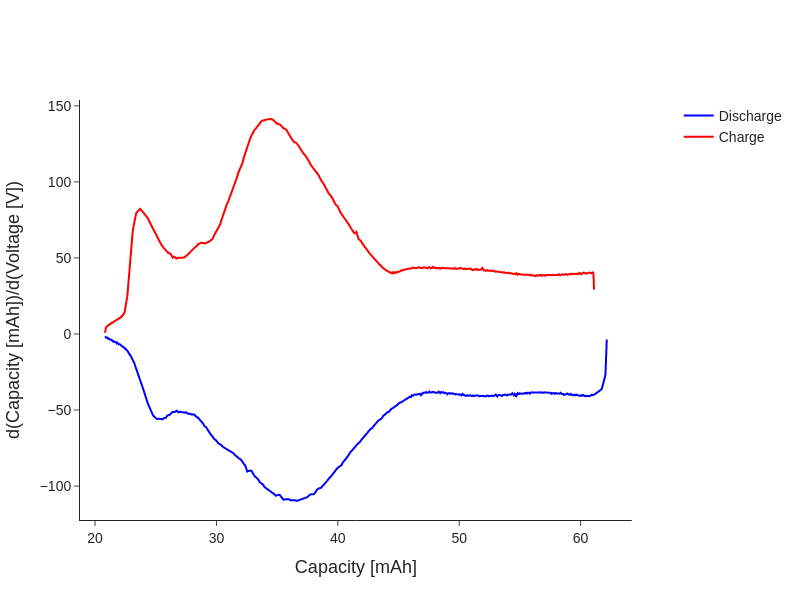

In [5]:
discharge_dQdV = discharge_differentiation.differentiate_LEAN(x = 'Capacity [mAh]', y='Voltage [V]', k = 10, gradient = 'dxdy')
charge_dQdV = charge_differentiation.differentiate_LEAN(x = 'Capacity [mAh]', y='Voltage [V]', k = 10, gradient = 'dxdy')
fig = pyprobe.Plot()
fig.add_line(discharge_dQdV, 'Capacity [mAh]', 'd(Capacity [mAh])/d(Voltage [V])', label='Discharge', color='blue')
fig.add_line(charge_dQdV, 'Capacity [mAh]', 'd(Capacity [mAh])/d(Voltage [V])', label='Charge', color='red')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation

To align the curves, we can instead plot `Cycle Capacity [Ah]` which is set to zero at the beginning of the filtered cycle.

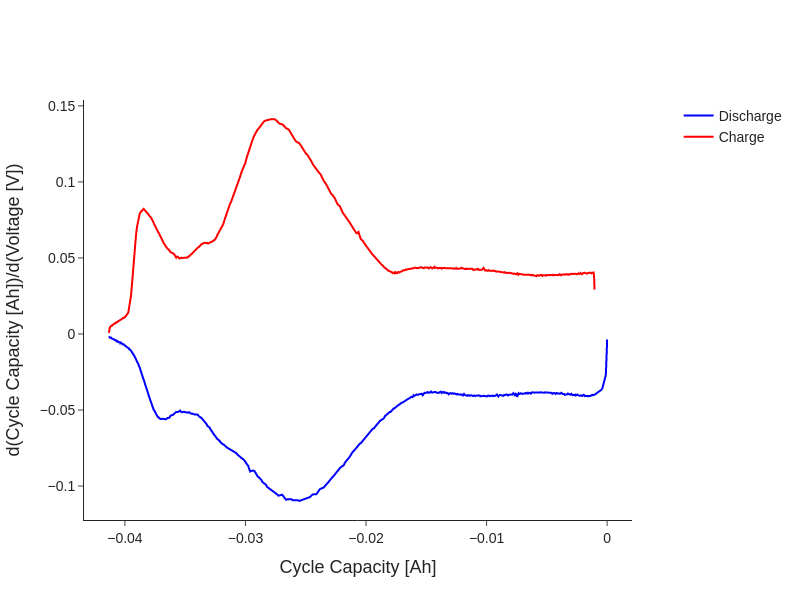

In [6]:
discharge_dQdV = discharge_differentiation.differentiate_LEAN(x = 'Cycle Capacity [Ah]', y='Voltage [V]', k = 10, gradient = 'dxdy')
charge_dQdV = charge_differentiation.differentiate_LEAN(x = 'Cycle Capacity [Ah]', y='Voltage [V]', k = 10, gradient = 'dxdy')
fig = pyprobe.Plot()
fig.add_line(discharge_dQdV, 'Cycle Capacity [Ah]', 'd(Cycle Capacity [Ah])/d(Voltage [V])', label='Discharge', color='blue')
fig.add_line(charge_dQdV, 'Cycle Capacity [Ah]', 'd(Cycle Capacity [Ah])/d(Voltage [V])', label='Charge', color='red')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation

The LEAN method is only applicable when the `x` data is uniformly spaced. The example above uses the default method behaviour of differentiating only the longest uniformly spaced period. If your `x` data has multiple uniformly spaced periods, however, you can use this method with the `section = 'all'` option.

The pulse below has two sampling periods:

dt =  [0.1 0.1 0.1 ... 1.  1.  1. ]


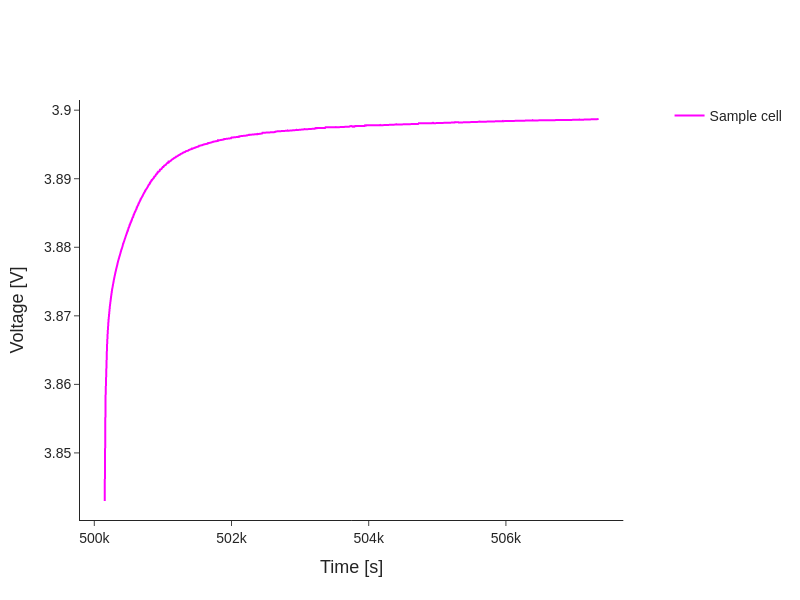

In [7]:
pulse_rest = cell.procedure['Sample'].experiment('Discharge Pulses').rest(7,8)
print('dt = ', np.diff(pulse_rest.get('Time [s]')))

fig = pyprobe.Plot()
fig.add_line(pulse_rest, 'Time [s]', 'Voltage [V]')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation